In [1]:
import time
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset import ImageDataset
import torch.nn.functional as F
from torchmetrics import Precision, Recall
from torchvision.models import resnet50
import warnings
from collections import defaultdict
import wandb
import datetime
import os
warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('high')
#intecubic interpol

run_name = f'resnet50_normalize{datetime.datetime.now()}'
run_path = f'training_checkpoints/{run_name}'

wandb.init(project="cells", 
           entity="adamsoja",
          name=run_name)

import random
random.seed(2233)
torch.manual_seed(2233)

#After /255 so in loading dataset there are no division by 255 just this normalization
mean = [0.5006, 0.3526, 0.5495]
std = [0.1493, 0.1341, 0.1124]


from albumentations import (
    Compose,
    Resize,
    OneOf,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    VerticalFlip,
    HorizontalFlip,
    ShiftScaleRotate,
    Normalize,
)

transform = Compose(
    [
        Normalize(mean=mean, std=std),
        OneOf([RandomBrightness(limit=0.4, p=1), RandomContrast(limit=0.4, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.7,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
    ]
)

transform_test = Compose(
    [Normalize(mean=mean, std=std)]
)

class MyModel(nn.Module):
    def __init__(self, model, learning_rate, weight_decay):
        super(MyModel, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()
        self.metric_precision = Precision(task="multiclass", num_classes=4, average=None).to('cuda')
        self.metric_recall = Recall(task="multiclass", num_classes=4, average=None).to('cuda')
        self.train_loss = []
        self.valid_loss = []
        self.precision_per_epochs = []
        self.recall_per_epochs = []

        self.optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", factor=0.1, patience=2, min_lr=5e-6, verbose=True)
        self.step = 0

    
    def forward(self, x):
        return self.model(x)

    def train_one_epoch(self, trainloader):
        self.step += 1
        self.train()
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            _, preds = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            self.metric_precision(preds, labels)
            self.metric_recall(preds, labels)
            self.train_loss.append(loss.item())


        

        
        avg_loss = np.mean(self.train_loss)
        self.train_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        self.precision_per_epochs.append(precision)
        self.recall_per_epochs.append(recall)
        print(f'train_loss: {avg_loss}')
        print(f'train_precision: {precision}')
        print(f'train_recall: {recall}')

        wandb.log({'loss': avg_loss},step=self.step)
        wandb.log({'Normal precision': precision[0].item()},step=self.step)
        wandb.log({'Inflamatory precision': precision[1].item()},step=self.step)
        wandb.log({'Tumor precision': precision[2].item()},step=self.step)
        wandb.log({'Other precision': precision[3].item()},step=self.step)


        wandb.log({'Normal recall': recall[0].item()},step=self.step)
        wandb.log({'Inflamatory recall': recall[1].item()},step=self.step)
        wandb.log({'Tumor recall': recall[2].item()},step=self.step)
        wandb.log({'Other recall': recall[3].item()},step=self.step)
        
        
        self.metric_precision.reset()
        self.metric_recall.reset()


    

    def evaluate(self, testloader):
        self.eval()
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                self.metric_precision(preds, labels)
                self.metric_recall(preds, labels)
                self.valid_loss.append(loss.item())
    
        avg_loss = np.mean(self.valid_loss)
        self.scheduler.step(avg_loss)
        self.valid_loss.clear()
        precision = self.metric_precision.compute()
        recall = self.metric_recall.compute()
        print(f'val_loss: {avg_loss}')
        print(f'val_precision: {precision}')
        print(f'val_recall: {recall}')
        self.metric_precision.reset()
        self.metric_recall.reset()

        wandb.log({'val_loss': avg_loss}, step=self.step)
        
        wandb.log({'val_Normal precision': precision[0].item()},step=self.step)
        wandb.log({'val_Inflamatory precision': precision[1].item()},step=self.step)
        wandb.log({'val_Tumor precision': precision[2].item()},step=self.step)
        wandb.log({'val_Other precision': precision[3].item()},step=self.step)


        wandb.log({'val_Normal recall': recall[0].item()},step=self.step)
        wandb.log({'val_Inflamatory recall': recall[1].item()},step=self.step)
        wandb.log({'val_Tumor recall': recall[2].item()},step=self.step)
        wandb.log({'val_Other recall': recall[3].item()},step=self.step)


        for param_group in self.optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']}")
        return avg_loss

torch.cuda.empty_cache()
batch_size = 256

trainset = ImageDataset(data_path='train_data', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)

testset = ImageDataset(data_path='validation_data', transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


learning_rate = 0.001
weight_decay = 0.00001

model = resnet50()
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
num_classes = 4
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.fc.in_features, num_classes))
model = model.to('cuda')


my_model = MyModel(model=model, learning_rate=learning_rate, weight_decay=weight_decay)
my_model = my_model.to('cuda')

num_epochs = 100
early_stop_patience = 10
best_val_loss = float('inf')
best_model_state_dict = None

for epoch in range(num_epochs):
    print('========================================')
    print(f'EPOCH: {epoch}') 
    time_start = time.perf_counter()
    my_model.train_one_epoch(trainloader)
    val_loss = my_model.evaluate(testloader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = my_model.state_dict()
        torch.save(best_model_state_dict, f'{run_path}.pth')
        
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch} with best validation loss {best_val_loss}")
        break
    time_epoch = time.perf_counter() - time_start
    print(f'epoch {epoch} time:  {time_epoch/60}')
    print('--------------------------------')

# Load the best model state dict
print(f'{run_path}.pth')
my_model.load_state_dict(torch.load(f'{run_path}.pth'))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


EPOCH: 0
train_loss: 0.9568212883813041
train_precision: tensor([0.5450, 0.6493, 0.6232, 0.4748], device='cuda:0')
train_recall: tensor([0.5236, 0.7497, 0.6103, 0.0258], device='cuda:0')
val_loss: 0.9023796223931843
val_precision: tensor([0.6251, 0.6897, 0.6837, 0.6384], device='cuda:0')
val_recall: tensor([0.5286, 0.8271, 0.6989, 0.2104], device='cuda:0')
Learning rate: 0.001
epoch 0 time:  1.0195901674833445
--------------------------------
EPOCH: 1
train_loss: 0.8451928175631024
train_precision: tensor([0.5913, 0.6867, 0.6601, 0.5230], device='cuda:0')
train_recall: tensor([0.5647, 0.7707, 0.6607, 0.1131], device='cuda:0')
val_loss: 0.7741004230247603
val_precision: tensor([0.6340, 0.7555, 0.6571, 0.5367], device='cuda:0')
val_recall: tensor([0.5350, 0.7744, 0.7785, 0.2488], device='cuda:0')
Learning rate: 0.001
epoch 1 time:  1.0500987459000044
--------------------------------
EPOCH: 2
train_loss: 0.8348456785082817
train_precision: tensor([0.5977, 0.6936, 0.6620, 0.5283], device='

<All keys matched successfully>

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import numpy as np
import torch 
from torchvision.models import resnet18
import torch.nn as nn


def test_report(model, dataloader):
    """Prints confusion matrix for testing dataset
    dataloader should be of batch_size=1."""

    y_pred = []
    y_test = []
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            label = label.numpy()
            output = output.numpy()
            y_pred.append(np.argmax(output))
            y_test.append(np.argmax(label))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

testset =ImageDataset(data_path='test_data', transform=transform_test)
dataloader = DataLoader(testset, batch_size=1, shuffle=True)

test_report(my_model.to('cpu'), dataloader)

[[676 105 212   7]
 [114 828  53   5]
 [122  53 817   8]
 [ 17   9  15  59]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.70      1000
           1       0.83      0.83      0.83      1000
           2       0.74      0.82      0.78      1000
           3       0.75      0.59      0.66       100

    accuracy                           0.77      3100
   macro avg       0.76      0.73      0.74      3100
weighted avg       0.77      0.77      0.77      3100



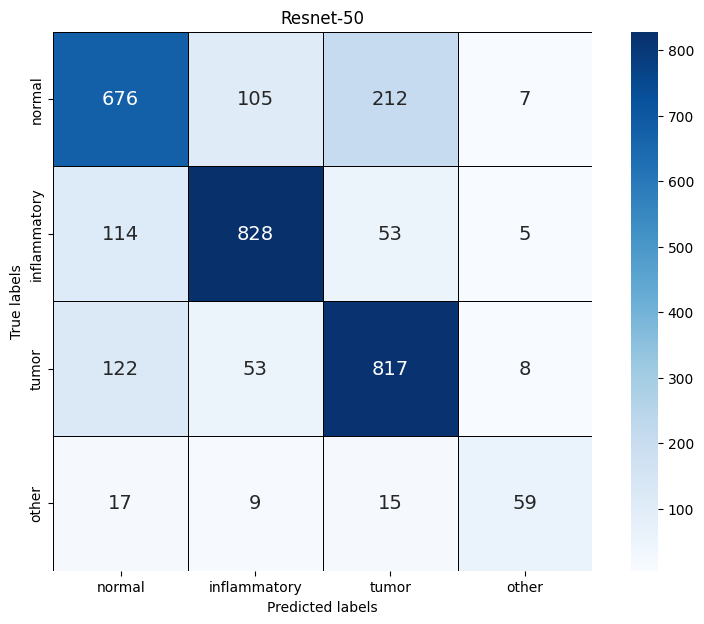

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the new confusion matrix
confusion_matrix = np.array([
    [676, 105, 212,   7],
    [114, 828,  53,   5],
    [122,  53, 817,   8],
    [ 17,   9,  15,  59]
])

# Create a heatmap with annotations
labels = ['normal', 'inflammatory', 'tumor', 'other']

# Create a heatmap with larger text annotations and axis labels
plt.figure(figsize=(10, 7))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                 cbar=True, square=True, linewidths=0.5, linecolor='black',
                 annot_kws={"size": 14},  # Increase text size here
                 xticklabels=labels,  # Set x-axis labels
                 yticklabels=labels)  # Set y-axis labels

# Set labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Resnet-50')

# Show the plot
plt.show()
